## Bron
http://www.femto-st.fr/en/Research-departments/AS2M/Research-groups/PHM/IEEE-PHM-2012-Data-challenge.php

## Setup
Datasets opgenomen onder 3 verschillende condities.

Regarding the PHM challenge, data representing 3 dierent loads were considered:

- First operating conditions: 1800 rpm and 4000 N;
- Second operating conditions: 1650 rpm and 4200 N;
- Third operating conditions: 1500 rpm and 5000 N.

```
Cond1      Cond2      Cond3
Learning set  
Bearing1_1 Bearing2_1 Bearing3_1  
Bearing1_2 Bearing2_2 Bearing3_2  

Test set 
Bearing1_3 Bearing2_3 Bearing3_3  
Bearing1_4 Bearing2_4  
Bearing1_5 Bearing2_5  
Bearing1_6 Bearing2_6
Bearing1_7 Bearing2_7  
```

## Organization of data
* files: acc_xxxxx.csv, and temp_xxxxx.csv
* Vibration signals (horizontal and vertical)
    - Sampling frequency: 25.6 kHz
    - Recordings: 2560 samples (i.e. 1/10 s) are recorded each 10 seconds (see Fig. 6)
* Temperature signals
    - Sampling frequency: 10 Hz
    - Recordings: 600 samples are recorded each minute
    
File inhoud:
```
Column         1     2      3     4            5            6
Vibr. signal Hour Minute Second mu-second Horiz. accel. vert. accel.
Temp. signal Hour Minute Second 0.x second Rtd sensor        -
```


## init cells

In [94]:
## imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from glob import glob
import h2o
from h2o.estimators import H2OAutoEncoderEstimator

In [30]:
fs = 25600
nrSamples = fs / 10
bearing_folder = '/Users/etto/Desktop/tpDatasets/FEMTOBearingDataSet/Learning_set/Bearing1_1/'
fileformat = 'acc_{:05d}.csv'
nrFiles = len(glob(bearing_folder + 'acc*csv'))
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,33 secs
H2O cluster timezone:,Europe/Amsterdam
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.8
H2O cluster version age:,12 days
H2O cluster name:,H2O_from_python_etto_56mk2k
H2O cluster total nodes:,1
H2O cluster free memory:,1.612 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


## plot one file

In [3]:
first_file = 'acc_00001.csv'

In [4]:
column_names = ['hour', 'minute','second','micsec','horAcc','vertAcc']
data = pd.read_csv(bearing_folder + first_file,names=column_names)

In [5]:
data.columns

Index(['hour', 'minute', 'second', 'micsec', 'horAcc', 'vertAcc'], dtype='object')

In [6]:
horAccs = data['horAcc']
horAccs.size

2560

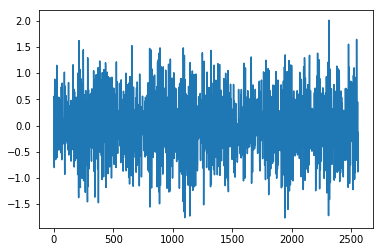

In [7]:
fig = plt.plot(horAccs)

In [8]:
# calculate energy
hA = np.array(horAccs)
energy = hA.std() # RMS value
print(energy)

0.5617349696566


## plot overzicht

In [9]:
energies = []
for nr in range(1, nrFiles+1):
    filename = bearing_folder + fileformat.format(nr)
    horAccs = pd.read_csv(filename,names=column_names)['horAcc']
    energies.append(np.array(horAccs).std())

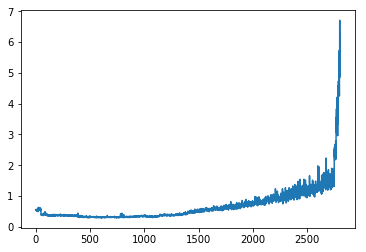

In [10]:
fig = plt.plot(energies)

In [12]:
energies = []
for nr in range(1, nrFiles+1):
    filename = bearing_folder + fileformat.format(nr)
    accs = pd.read_csv(filename,names=column_names)['vertAcc']
    energies.append(np.array(accs).std())

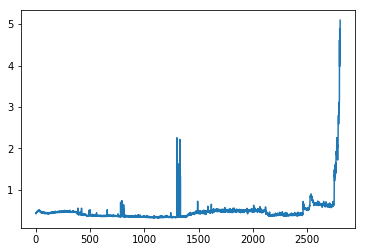

In [13]:
fig = plt.plot(energies)

## spectrogram van bearing 1

In [ ]:
# construeer hele signaal
signal_bearing_1_1_hor = []
for nr in range(1, nrAccs+1):
    filename = bearing_folder + fileformat.format(nr)
    horAccs = pd.read_csv(filename,names=column_names)['horAcc']
    signal_bearing_1_1_hor = np.append(signal, np.array(horAccs))

In [ ]:
%store signal_bearing_1_1_hor

In [14]:
%store -r signal_bearing_1_1_hor

In [15]:
np.shape(signal_bearing_1_1_hor)

(7175680,)

In [16]:
7175680 / 2560

2803.0

In [17]:
freq_array, segment_times, spectogram = sig.spectrogram(x=signal_bearing_1_1_hor, fs=25600, nperseg=2560,noverlap=0)

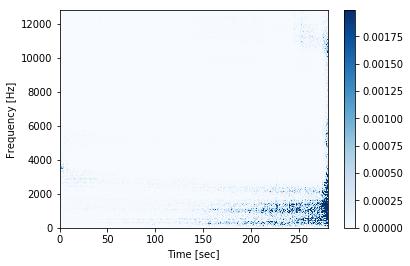

In [18]:
z_min, z_max = -np.abs(spectogram).max(), np.abs(spectogram).max()
plt.pcolormesh(segment_times, freq_array, spectogram, cmap='Blues', vmin=0, vmax=z_max/100)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()

In [19]:
print(np.shape(spectogram))
print(z_max)

(1281, 2803)
0.19883814896826307


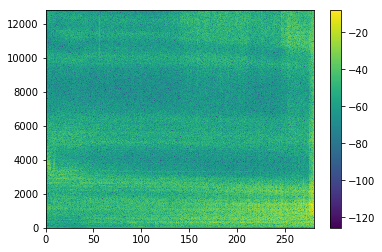

In [20]:
Pxx, freqs, bins, im = plt.specgram(signal_bearing_1_1_hor, NFFT=2560, Fs=25600, noverlap=0)
plt.colorbar()

In [22]:
np.shape(spectogram)

(1281, 2803)

## Autoencode spectrogram

In [24]:
%store -r signal_bearing_1_1_hor
freq_array, segment_times, spectrogram = sig.spectrogram(x=signal_bearing_1_1_hor, fs=25600, nperseg=2560,noverlap=0)

In [92]:
# configuration parameters
_vr_auto_encoder = 0.1 # validation ratio for autoencoder
np_spec = np.array(spectrogram).T
nr_auto_encode = int(_vr_auto_encoder * len(np_spec))
idx_all = range(len(np_spec))
idx_vr = np.random.choice(idx_all, size=nr_auto_encode,replace=False)

np_verify = np_spec[idx_vr]
np_train = np_spec[np.delete(idx_all,idx_vr,0)]
print(len(np_verify))
print(len(np_train))

h_train = h2o.H2OFrame(np_train)
h_verify = h2o.H2OFrame(np_verify)

280
2523
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [93]:
h_train.describe()

Rows:2523
Cols:1281




C1 C2 C3 C4 C5 C6 C7 C8 C9 C10 C11 C12 C13 C14 C15 C16 C17 C18 C19 C20 C21 C22 C23 C24 C25 C26 C27 C28 C29 C30 C31 C32 C33 C34 C35 C36 C37 C38 C39 C40 C41 C42 C43 C44 C45 C46 C47 C48 C49 C50 C51 C52 C53 C54 C55 C56 C57 C58 C59 C60 C61 C62 C63 C64 C65 C66 C67 C68 C69 C70 C71 C72 C73 C74 C75 C76 C77 C78 C79 C80 C81 C82 C83 C84 C85 C86 C87 C88 C89 C90 C91 C92 C93 C94 C95 C96 C97 C98 C99 C100 C101 C102 C103 C104 C105 C106 C107 C108 C109 C110 C111 C112 C113 C114 C115 C116 C117 C118 C119 C120 C121 C122 C123 C124 C125 C126 C127 C128 C129 C130 C131 C132 C133 C134 C135 C136 C137 C138 C139 C140 C141 C142 C143 C144 C145 C146 C147 C148 C149 C150 C151 C152 C153 C154 C155 C156 C157 C158 C159 C160 C161 C162 C163 C164 C165 C166 C167 C168 C169 C170 C171 C172 C173 C174 C175 C176 C177 C178 C179 C180 C181 C182 C183 C184 C185 C186 C187 C188 C189 C190 C191 C192 C193 C194 C195 C196 C197 C198 C199 C200 C201 C202 C203 C204 C205 C206 C207 C208 C209 C210 C211 C212 C213 C214 C215 C216 C217 C218 C219 C220 C221 C222 C223 C224 C225 C226 C227 C228 C229 C230 C231 C232 C233 C234 C235 C236 C237 C238 C239 C240 C241 C242 C243 C244 C245 C246 C247 C248 C249 C250 C251 C252 C253 C254 C255 C256 C257 C258 C259 C260 C261 C262 C263 C264 C265 C266 C267 C268 C269 C270 C271 C272 C273 C274 C275 C276 C277 C278 C279 C280 C281 C282 C283 C284 C285 C286 C287 C288 C289 C290 C291 C292 C293 C294 C295 C296 C297 C298 C299 C300 C301 C302 C303 C304 C305 C306 C307 C308 C309 C310 C311 C312 C313 C314 C315 C316 C317 C318 C319 C320 C321 C322 C323 C324 C325 C326 C327 C328 C329 C330 C331 C332 C333 C334 C335 C336 C337 C338 C339 C340 C341 C342 C343 C344 C345 C346 C347 C348 C349 C350 C351 C352 C353 C354 C355 C356 C357 C358 C359 C360 C361 C362 C363 C364 C365 C366 C367 C368 C369 C370 C371 C372 C373 C374 C375 C376 C377 C378 C379 C380 C381 C382 C383 C384 C385 C386 C387 C388 C389 C390 C391 C392 C393 C394 C395 C396 C397 C398 C399 C400 C401 C402 C403 C404 C405 C406 C407 C408 C409 C410 C411 C412 C413 C414 C415 C416 C417 C418 C419 C420 C421 C422 C423 C424 C425 C426 C427 C428 C429 C430 C431 C432 C433 C434 C435 C436 C437 C438 C439 C440 C441 C442 C443 C444 C445 C446 C447 C448 C449 C450 C451 C452 C453 C454 C455 C456 C457 C458 C459 C460 C461 C462 C463 C464 C465 C466 C467 C468 C469 C470 C471 C472 C473 C474 C475 C476 C477 C478 C479 C480 C481 C482 C483 C484 C485 C486 C487 C488 C489 C490 C491 C492 C493 C494 C495 C496 C497 C498 C499 C500 C501 C502 C503 C504 C505 C506 C507 C508 C509 C510 C511 C512 C513 C514 C515 C516 C517 C518 C519 C520 C521 C522 C523 C524 C525 C526 C527 C528 C529 C530 C531 C532 C533 C534 C535 C536 C537 C538 C539 C540 C541 C542 C543 C544 C545 C546 C547 C548 C549 C550 C551 C552 C553 C554 C555 C556 C557 C558 C559 C560 C561 C562 C563 C564 C565 C566 C567 C568 C569 C570 C571 C572 C573 C574 C575 C576 C577 C578 C579 C580 C581 C582 C583 C584 C585 C586 C587 C588 C589 C590 C591 C592 C593 C594 C595 C596 C597 C598 C599 C600 C601 C602 C603 C604 C605 C606 C607 C608 C609 C610 C611 C612 C613 C614 C615 C616 C617 C618 C619 C620 C621 C622 C623 C624 C625 C626 C627 C628 C629 C630 C631 C632 C633 C634 C635 C636 C637 C638 C639 C640 C641 C642 C643 C644 C645 C646 C647 C648 C649 C650 C651 C652 C653 C654 C655 C656 C657 C658 C659 C660 C661 C662 C663 C664 C665 C666 C667 C668 C669 C670 C671 C672 C673 C674 C675 C676 C677 C678 C679 C680 C681 C682 C683 C684 C685 C686 C687 C688 C689 C690 C691 C692 C693 C694 C695 C696 C697 C698 C699 C700 C701 C702 C703 C704 C705 C706 C707 C708 C709 C710 C711 C712 C713 C714 C715 C716 C717 C718 C719 C720 C721 C722 C723 C724 C725 C726 C727 C728 C729 C730 C731 C732 C733 C734 C735 C736 C737 C738 C739 C740 C741 C742 C743 C744 C745 C746 C747 C748 C749 C750 C751 C752 C753 C754 C755 C756 C757 C758 C759 C760 C761 C762 C763 C764 C765 C766 C767 C768 C769 C770 C771 C772 C773 C774 C775 C776 C777 C778 C779 C780 C781 C782 C783 C784 C785 C786 C787 C788 C789 C790 C791 C792 C793 C794 C795 C796 C797 C798 C799 C800 C801 C802 C803 C804 C805 C806 C807 C808 C809 C810 C811 C812 C813 C814 C815 C816 C817 C818 C819 C820 C821 C82

In [95]:
auto_encoder_model = H2OAutoEncoderEstimator(activation='Tanh',hidden=[25], 
                                            epochs=150, loss='Quadratic', distribution='gaussian')
auto_encoder_model.train(x=h_train.columns, training_frame=h_train, validation_frame=h_verify)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [102]:
h2o.cluster().shutdown()